# 『2과목』 Deep-learning

## Set Up

In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # Windows
# matplotlib.rcParams['font.family'] = 'AppleGothic' # Mac
matplotlib.rcParams['font.size'] = 15 # 글자 크기
matplotlib.rcParams['axes.unicode_minus'] = False # 한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결

In [2]:
import numpy as np

print(np.__version__)

2.1.3


In [4]:
import tensorflow as tf

print(tf.executing_eagerly())

True


In [3]:
# import tensorflow as tf
# print(tf.executing_eagerly())

if False :
    
import tensorflow as tf
tf.config.run_functions_eagerly(True)

재시작 후 다시 실행

## 전이 학습

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.preprocessing import image
import os

train_folder='./datasets/CUB200/train'
test_folder='./datasets/CUB200/test'

class_reduce=0.1 # 부류 수 줄여서 데이터양 줄임(속도와 메모리 효율을 위해)
no_class=int(len(os.listdir(train_folder))*class_reduce) # 부류 개수

x_train,y_train=[],[]
for i,class_name in enumerate(os.listdir(train_folder)):
    if i<no_class: # 13~14행이 지정한 부류만 사용
        for fname in os.listdir(train_folder+'/'+class_name):
            img=image.load_img(train_folder+'/'+class_name+'/'+fname,target_size=(224,224))
            if len(img.getbands())!=3:
                print("주의: 유효하지 않은 영상 발생",class_name,fname)
                continue
            x=image.img_to_array(img)
            x=preprocess_input(x)
            x_train.append(x)
            y_train.append(i)
x_test,y_test=[],[]
for i,class_name in enumerate(os.listdir(test_folder)):
    if i<no_class: # 13~14행이 지정한 부류만 사용
        for fname in os.listdir(test_folder+'/'+class_name):
            img=image.load_img(test_folder+'/'+class_name+'/'+fname,target_size=(224,224))
            if len(img.getbands())!=3:
                print("주의: 유효하지 않은 영상 발생",class_name,fname)
                continue
            x=image.img_to_array(img)
            x=preprocess_input(x)
            x_test.append(x)
            y_test.append(i)

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)
y_train=tf.keras.utils.to_categorical(y_train,no_class)
y_test=tf.keras.utils.to_categorical(y_test,no_class)

base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
cnn=Sequential()
cnn.add(base_model)
cnn.add(Flatten())
cnn.add(Dense(1024,activation='relu'))
cnn.add(Dense(no_class,activation='softmax'))

cnn.compile(loss='categorical_crossentropy',optimizer=Adam(0.00002),metrics=['accuracy'])
hist=cnn.fit(x_train,y_train,batch_size=16,epochs=10,validation_data=(x_test,y_test),verbose=1)

res=cnn.evaluate(x_test,y_test,verbose=0)
print("정확률은",res[1]*100)

# YOLO는 SamsungDisplay_5th-7_YOLOv8.ipynb 파일을 참조


## Fast R-CNN

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

# VGG16 모델을 백본으로 사용
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_output = base_model.output
base_model_output = Flatten()(base_model_output)

# 클래스 예측을 위한 완전 연결층
num_classes = 20  # 예: PASCAL VOC 데이터셋의 클래스 수
class_output = Dense(num_classes, activation='softmax', name='class_output')(base_model_output)

# 바운딩 박스 예측을 위한 완전 연결층
bbox_output = Dense(4, activation='linear', name='bbox_output')(base_model_output)

# 모델 정의
model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])

# 모델 컴파일
model.compile(optimizer='adam',
              loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

# 모델 요약 출력
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 224, 224, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 224, 224, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 112, 112, 64)      │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 112, 112, 128)     │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 112, 112, 128)     │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 56, 56, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 56, 56, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 28, 28, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 28, 28, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 14, 14, 512)       │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 15,316,824 (58.43 MB)

 Trainable params: 15,316,824 (58.43 MB)

 Non-trainable params: 0 (0.00 B)

## U-Net

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# U-Net 모델 정의
inputs = Input((128, 128, 1))

c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

u3 = UpSampling2D((2, 2))(c2)
u3 = concatenate([u3, c1], axis=3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c3)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │             640 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 128, 128, 128)     │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 192)     │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 64)      │         110,656 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 128, 128, 1)       │              65 │ conv2d_5[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 406,657 (1.55 MB)

 Trainable params: 406,657 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

## 지능 에이전트

### 영상 바구니 담기

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

# CIFAR-10 데이터셋을 읽고 신경망에 입력할 형태로 변환
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
x_train=x_train.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0
y_train=tf.keras.utils.to_categorical(y_train,10)
y_test=tf.keras.utils.to_categorical(y_test,10)

# 신경망 모델 설계
cnn=Sequential()
cnn.add(Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
cnn.add(Conv2D(32,(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(64,(3,3),activation='relu'))
cnn.add(Conv2D(64,(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(512,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10,activation='softmax'))

# 신경망 모델 학습
cnn.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
hist=cnn.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),verbose=2)

# 신경망 모델 정확률 평가
res=cnn.evaluate(x_test,y_test,verbose=0)
print("정확률은",res[1]*100)

import matplotlib.pyplot as plt

# 정확률 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

# 손실 함수 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='best')
plt.grid()
plt.show()
cnn.save("my_cnn_for_deploy.h5")

c:\DEV\envs\py3_10_tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
391/391 - 80s - 204ms/step - accuracy: 0.4019 - loss: 1.6258 - val_accuracy: 0.5231 - val_loss: 1.3059
Epoch 2/100
391/391 - 45s - 114ms/step - accuracy: 0.5519 - loss: 1.2490 - val_accuracy: 0.6176 - val_loss: 1.0744
Epoch 3/100
391/391 - 36s - 92ms/step - accuracy: 0.6156 - loss: 1.0872 - val_accuracy: 0.6639 - val_loss: 0.9831
Epoch 4/100
391/391 - 42s - 107ms/step - accuracy: 0.6582 - loss: 0.9674 - val_accuracy: 0.7027 - val_loss: 0.8665
Epoch 5/100
391/391 - 36s - 92ms/step - accuracy: 0.6850 - loss: 0.8874 - val_accuracy: 0.6989 - val_loss: 0.8768
Epoch 6/100
391/391 - 36s - 93ms/step - accuracy: 0.7120 - loss: 0.8291 - val_accuracy: 0.7430 - val_loss: 0.7499
Epoch 7/100


### 영상을 인식하고 부류 확률을 막대로 그림

c:\DEV\envs\py3_10_tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\DEV\envs\py3_10_tf\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


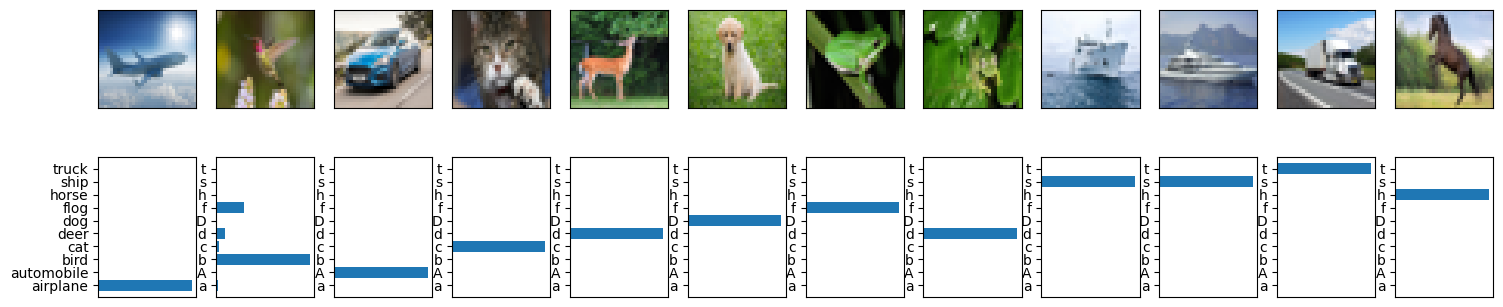

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import os

cnn=tf.keras.models.load_model("my_cnn_for_deploy.h5") # 학습된 모델 불러오기
class_names=['airplane','automobile','bird','cat','deer','dog','flog','horse','ship','truck'] # CIFAR-10의 부류 이름

x_test=[]
for filename in os.listdir("datasets/test_images"): # 폴더에서 테스트 영상 읽기
    if 'jpg' not in filename:
        continue
    img=Image.open("datasets/test_images/"+filename)
    x=np.asarray(img.resize([32,32]))/255.0
    x_test.append(x)
x_test=np.asarray(x_test)

pred=cnn.predict(x_test) # 예측

import matplotlib.pyplot as plt

n=len(x_test)
plt.figure(figsize=(18,4))

for i in range(n):
    plt.subplot(2,n,i+1)
    plt.imshow(x_test[i])
    plt.xticks([]);plt.yticks([])
    plt.subplot(2,n,n+i+1)
    if i==0:
        plt.barh(class_names,pred[i])
    else:
        plt.barh(['a','A','b','c','d','D','f','h','s','t'],pred[i])
    plt.xticks([])

### 영상 바구니 담기

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import os

cnn=tf.keras.models.load_model('my_cnn_for_deploy.h5') # 학습된 모델 불러오기
class_names=['airplane','automobile','bird','cat','deer','dog','flog','horse','ship','truck'] # CIFAR-10의 부류 이름

x_test=[]
img_orig=[]
fname=[]
for filename in os.listdir('datasets/test_images'): # 폴더에서 테스트 영상 읽기
    if 'jpg' not in filename:
        continue
    img=Image.open('datasets/test_images/'+filename)
    img_orig.append(img)
    fname.append(filename)
    x=np.asarray(img.resize([32,32]))/255.0
    x_test.append(x)
x_test=np.asarray(x_test)

pred=cnn.predict(x_test) # 예측

os.chdir('datasets/test_images')
if not os.path.isdir('class_buckets'):
    os.mkdir('class_buckets')
os.chdir('class_buckets')
for i in range(len(class_names)): # 부류별로 폴더 만들기
    if not os.path.isdir(class_names[i]):
        os.mkdir(class_names[i])

for i in range(len(x_test)): # 인식 결과에 따라 폴더에 저장
    folder_name=class_names[np.argmax(pred[i])]
    os.chdir(folder_name)
    img_orig[i].save(fname[i])
    os.chdir('..')

c:\DEV\envs\py3_10_tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\DEV\envs\py3_10_tf\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


# 기능 확장하기는 콘솔에서 실습

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# U-Net 모델 정의
inputs = Input((128, 128, 1))

c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

u3 = UpSampling2D((2, 2))(c2)
u3 = concatenate([u3, c1], axis=3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c3)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

##  딥러닝 모델의 음성  처리

### 소리 데이터 처리하기

In [ ]:
단계 1: 소리 데이터의 처리에 필요한 외부 모듈 설정하기

sampling rate:  22050
time :  0.7813605442176871
vData :  [  2899   3912   4583   4520   3852   2744   1496    725    890   1968
   3470   4616   4867   4266   3267   2566   2671   3451   4471   5311
   5480   4789   3642   2628   2172   2296   2552   2587   2365   1788
    812   -417  -1848  -3250  -4074  -4209  -4236  -4794  -6158  -8135
 -10150 -11595 -12089 -11715 -11148 -11117 -11836 -13066 -14205 -14524
 -13937 -13173 -12830 -12816 -12661 -11620  -8703  -3632   2073   5600
   5077   1793   -231   2004   7297  11561  11937   9086   5769   3724
   2460   1004   -461  -1253  -1480  -2055  -3581  -5579  -7018  -7343
  -6614  -4950  -2371    628   2774   2899   1316     -9    945   4290
   8101  10304  10278   8894   7496   6716   6502   6936   7903   8664]


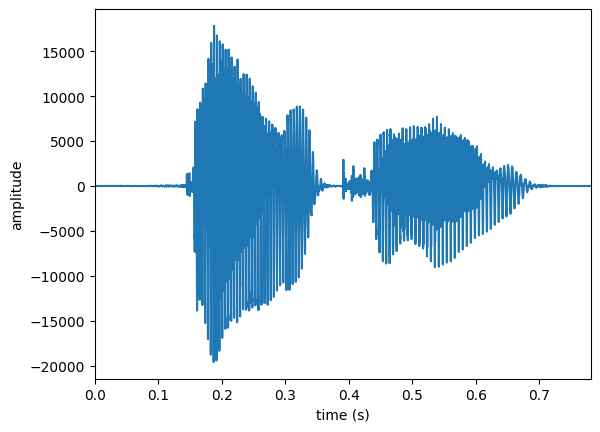

In [ ]:
# 소리 데이터에 필요한 외부 모듈 설정하기

# 소리 파일을 다루기 위한 모듈
import numpy as np                                    # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import matplotlib.pyplot as plt                       # 음성 데이터의 그래프 표현을 위한 모듈

import scipy.io.wavfile
import sounddevice as sd                              # 소리 데이터를 실제 스피커로 출력하기 위한 사운드 장치 모듈


# 작업 폴더에 저장된 ‘thank_you.wav’ 파일 읽기
v_samplerate, v_data = scipy.io.wavfile.read("datasets/thank_you.wav")
times = np.arange(len(v_data))/float(v_samplerate)     # x축 시간 정보를 구하기

print('sampling rate: ', v_samplerate)                 # wav 파일의 샘플링 주기를 출력
print('time : ', times[-1])                            # 소리의 재생 시간을 출력(times[ ]의 마지막 성분의 값)
print('vData : ', v_data[5000:5100])                   # 5000번째 샘플링 데이터부터 100개를 출력
sd.play(v_data, v_samplerate)                          # 읽어 들인 wav 파일을 사운드 장치로 출력

# wav 형식의 소리 데이터를 그래프로 출력(X축: 소요 시간, Y축: 소리의 높낮이 진폭값)
plt.plot(times, v_data)
plt.xlim(times[0], times[-1])
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.show()

### 소리 데이터 다루기

단계 1: 사인함수를 이용하여 임의의 소리 데이터 만들기

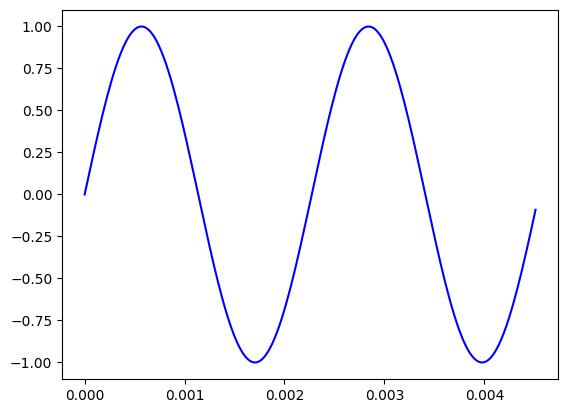

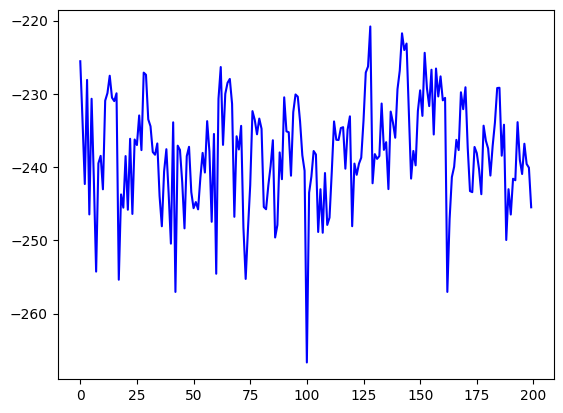

In [ ]:
# 소리 데이터에 필요한 외부 모듈과 환경 변수 설정하기

import numpy as np                             # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import matplotlib.pyplot as plt                # 소리 데이터의 그래프 표현을 위한 모듈
from scipy.io.wavfile import write             # wav 형식으로 소리 데이터를 저장하기 위한 모듈
import os                                      # wav 파일을 시스템 명령어로 재생하기 위한 모듈

# sampling rate
Fs = 44100.0                                   # 정보 샘플링 주기, 1초에 44100개의 샘플링, 단위는 Hz(주파수)

# 1초 데이터 생성을 위한 환경 변수 설정
tlen = 1                                       # 1초
Ts = 1/Fs                                      # 샘플링 사이의 간격(시간)
t = np.arange(0, tlen, Ts)                     # 소리 데이터를 생성할 시간 성분으로 구성된 배열로
                                               # [0, 1] 사이를 TimeStamp의 간격으로 분할하여
                                               # Fs 개의 데이터를 담을 수 있는 배열 t를 생성

# 시그널 생성하기
sin_freq = 440                                 # sin 곡선의 주기
src = 2*np.pi*sin_freq*t                       # t 배열의 각 성분값에 sin 주기를 라디안 단위로 변환한 src 배열을 준비
signal = np.sin(src)                           # timestamp를 각으로 변환한 src 배열에 맞게 sin 데이터를 변환

# 데이터의 가시화: 생성한 시그널 데이터를 그래프로 표현
x_range = 200                                  # 시작부터 200개의 데이터만 보여 주기 위한 범위값
plt.plot(t[0:x_range], signal[0:x_range], color = 'blue')    # x축의 timstamp에 sin 함수로 생성한 데이터를 y축에 좌푯값으로 그래프를 그림

plt.show()                                     # 200개의 데이터를 가시화한 그래프를 보여줌.

# 데이터의 가시화: 시그널 데이터를 푸리에 변환하여 주파수 영역에서 가시화함.
freq = np.fft.fftfreq(len(t), Ts)              # 주파수 영역에서의 샘플링 구간값의 배열
signal_f = np.fft.fft(signal)                  # sin 함수값으로부터 주파수 영역에서의 정보를 나타내기
                                               # 위한 푸리에 변환 값을 signal_f 배열로 저장
plt.plot(freq[0:x_range], 20*np.log10(np.abs(signal_f[0:x_range])), color='blue')
                                               # x축의 주파수 성분에 맞게 그래프를 그림.
plt.show()                                     # 푸리에 변환된 200개 데이터를 그래프로 출력

# sin 함수로 생성한 음성 데이터를 wav 형식의 파일로 저장
scaled = np.int16(signal/np.max(np.abs(signal)) * 32767)
write('snd_signal.wav', 44100, scaled)

단계 2: 생성한 소리 데이터를 wav 형식의 파일로 저장하기

In [ ]:
# 생성한 소리 데이터를 wav 형식의 파일로 저장하기

import numpy as np                             # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import matplotlib.pyplot as plt                # 소리 데이터의 그래프 표현을 위한 모듈
from scipy.io.wavfile import write             # wav 형식으로 소리 데이터를 저장하기 위한 모듈
import os                                      # wav 파일을 시스템 명령어로 재생하기 위한 모듈

# sampling rate
Fs = 44100.0                                   # 정보 샘플링 주기, 1초에 44100개의 샘플링, 단위는 Hz(주파수)

# 1초 데이터 생성을 위한 환경 변수 설정
tlen = 1                                       # 1초로 초기화
Ts = 1/Fs                                      # 샘플링 사이의 간격(시간) 계산
t = np.arange(0, tlen, Ts)                     # 소리 데이터를 생성할 시간 성분으로 구성된 배열로
                                               # [0, 1] 사이를 TimeStamp의 간격으로 분할하여
                                               # Fs 개의 데이터를 담을 수 있는 배열 t를 생성

# 시그널 생성하기
sin_freq = 440                                 # sin 곡선의 주기
src = 2*np.pi*sin_freq*t                       # t 배열의 각 성분값에 sin 주기를 라디안 단위로 변환한 src 배열을 준비
signal = np.sin(src)                           # timestamp를 각으로 변환한 src 배열에 맞게 sin 데이터를 변환

# -------------------------------------------------------------------------------
# sin 함수로 생성한 음성 데이터를 wav 형식의 파일로 저장
scaled = np.int16(signal/np.max(np.abs(signal)) * 32767)
write('snd_signal.wav', 44100, scaled)

In [ ]:
단계 3: 잡음 만들기

noise[0:20] = 
[ 0.5647297   0.9017093   0.18160465  0.23142009  0.92835954  0.95795906
 -0.02280939 -0.8134863  -0.05643187  0.64934198  0.24024661 -0.54512745
  0.76233241  0.18702228 -0.28222109 -0.57444955 -0.3456586  -0.43455999
  0.88530074  0.28139603]
scaled_noise[0:20] = 
[ 0.16941891  0.27051279  0.0544814   0.06942603  0.27850786  0.28738772
 -0.00684282 -0.24404589 -0.01692956  0.19480259  0.07207398 -0.16353824
  0.22869972  0.05610669 -0.08466633 -0.17233486 -0.10369758 -0.130368
  0.26559022  0.08441881]


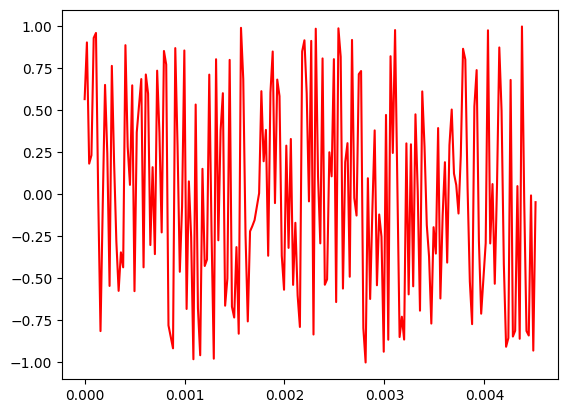

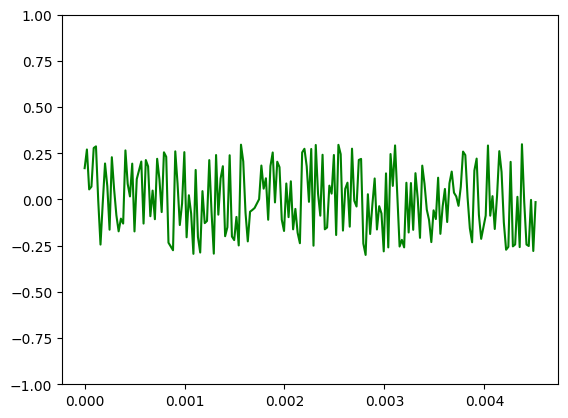

In [ ]:
import numpy as np                             # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import matplotlib.pyplot as plt                # 소리 데이터의 그래프 표현을 위한 모듈
from scipy.io.wavfile import write             # wav 형식으로 소리 데이터를 저장하기 위한 모듈
import os                                      # wav 파일을 시스템 명령어로 재생하기 위한 모듈

# sampling rate
Fs = 44100.0                                   # 정보 샘플링 주기, 1초에 44100개의 샘플링, 단위는 Hz(주파수)

# 1초 데이터 생성을 위한 환경 변수 설정
tlen = 1                                       # 1초로 초기화
Ts = 1/Fs                                      # 샘플링 사이의 간격(시간) 계산
t = np.arange(0, tlen, Ts)                     # 소리 데이터를 생성할 시간 성분으로 구성된 배열로
                                               # [0, 1] 사이를 TimeStamp의 간격으로 분할하여
                                               # Fs 개의 데이터를 담을 수 있는 배열 t를 생성

# 시그널 생성하기
sin_freq = 440                                 # sin 곡선의 주기
src = 2*np.pi*sin_freq*t                       # t 배열의 각 성분값에 sin 주기를 라디안 단위로 변환한 src 배열을 준비
signal = np.sin(src)                           # timestamp를 각으로 변환한 src 배열에 맞게 sin 데이터를 변환


# 데이터의 가시화: 생성한 시그널 데이터를 그래프로 표현
x_range = 200                                  # 시작부터 200개의 데이터만 보여 주기 위한 범위값

# -------------------------------------------------------------------------------------

noise = np.random.uniform(-1, 1, len(t))       # 균등분포의 난수로 구성된 잡음 데이터 생성
scaled_noise = noise * 0.3                     # noise 데이터의 볼륨을 30% 낮춤.

# 잡음 데이터와 볼륨을 낮춘 데이터 출력
print("noise[0:20] = ")
print(noise[0:20])
print("scaled_noise[0:20] = ")
print(scaled_noise[0:20])

# 데이터의 가시화: [-1, 1] 구간에서 생성한 잡음 데이터를 그래프로 표현
plt.plot(t[0:x_range], noise[0:x_range], color = 'red')
plt.show( )

# 데이터의 가시화: 원 데이터의 볼륨을 낮춘 scaled_noise 데이터를 그래프로 표현
plt.plot(t[0:x_range], scaled_noise[0:x_range], color = 'green')
plt.ylim(-1, 1) # Y축의 데이터 구간을 –1과 1로 지정
plt.show( )


# 생성한  잡음 데이터를 wav 형식의 파일로 저장
scaled = np.int16(noise/np.max(np.abs(noise)) * 32767)
write('noise_signal.wav', 44100, scaled)

### 소리 데이터 가공하기

사인 파형의 소리와 잡음 소리 합성하기

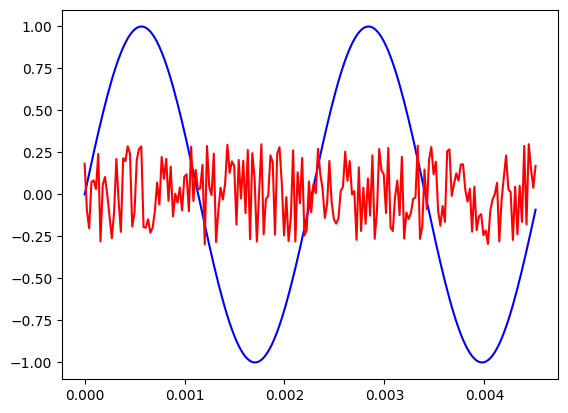

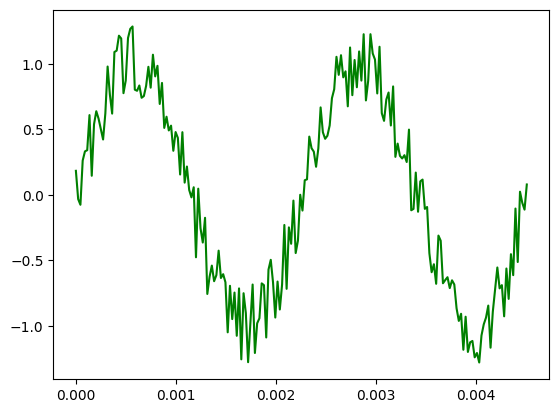

In [ ]:
# 생활 속의 소리 합성하기

import numpy as np                                         # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import matplotlib.pyplot as plt                            # 소리 데이터의 그래프 표현을 위한 모듈

import scipy.io as sio                                     # wav 형식으로 소리 데이터를 저장하기 위한 모듈
from scipy.io.wavfile import write                         # wav 파일을 시스템 명령어로 재생하기 위한 모듈
import os

# sampling rate
Fs = 44100.0                                   # 정보 샘플링 주기, 1초에 44100개의 샘플링, 단위는 Hz(주파수)

# 1초 데이터 생성을 위한 환경 변수 설정
tlen = 1                                       # 1초
Ts = 1/Fs                                      # 샘플링 사이의 간격(시간)
t = np.arange(0, tlen, Ts)                     # 소리 데이터를 생성할 시간 성분으로 구성된 배열로
                                               # [0, 1] 사이를 TimeStamp의 간격으로 분할하여
                                               # Fs 개의 데이터를 담을 수 있는 배열 t를 생성

# 시그널 생성하기
sin_freq = 440                                 # sin 곡선의 주기
src = 2*np.pi*sin_freq*t                       # t 배열의 각 성분값에 sin 주기를 라디안 단위로 변환한 src 배열을 준비
signal = np.sin(src)                           # timestamp를 각으로 변환한 src 배열에 맞게 sin 데이터를 변환


# 데이터의 가시화: 생성한 시그널 데이터를 그래프로 표현
x_range = 200                                  # 시작부터 200개의 데이터만 보여 주기 위한 범위값
noise = np.random.uniform(-1, 1, len(t))       # 균등분포의 난수로 구성된 잡음 데이터 생성

# -----------------------------------------------------------------------------------------
signal_n = signal + noise

# signal + noise로 두 소리 데이터를 산술적으로 더함.
scaled_noise = noise * 0.3                     # 소리 크기를 30% 줄이기
signal_n = signal + scaled_noise
# save as wav file
scaled = np.int16(signal_n/np.max(np.abs(signal_n)) * 32767)
write('snd_noise.wav', 44100, scaled)

#show the raw signals
plt.plot(t[0:x_range], signal[0:x_range], color = 'blue')
plt.plot(t[0:x_range], scaled_noise[0:x_range], color = 'red')
plt.show()

plt.plot(t[0:x_range], signal_n[0:x_range], color = 'green')
plt.show()

단계 2: 소리 듣기

In [ ]:
# [Step 1]에서 만든 소리 듣기

import os                   # wav 파일을 시스템 명령어로 재생하기 위한 모듈

os.system("start snd_signal.wav")
os.system("start noise_signal.wav")
os.system("start snd_noise.wav")

0

### 음성 카드 만들기

단계1: 나만의 소리 파일의 데이터와 샘플링 주파수 확인하기

In [ ]:
# 나만의 소리 파일의 데이터와 샘플링 주기 확인하기

import numpy as np                                         # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import scipy.io as sio
from scipy.io.wavfile import write                         # wav 파일을 시스템 명령어로 재생하기 위한 모듈
import os

# sampling rate
v_samplerate, v_data = sio.wavfile.read("datasets/thank_you.wav")
b_samplerate, b_data = sio.wavfile.read("datasets/Invisible_Beauty.wav")

v_times = np.arange(len(v_data))/float(v_samplerate)
b_times = np.arange(len(b_data))/float(b_samplerate)

print('sampling rate: ', v_samplerate, b_samplerate)
print('time : ', v_times[-1], b_times[-1])
print('len : ', len(v_data), len(b_data))

print(v_data.shape)
print(b_data.shape)

sampling rate:  22050 44100
time :  0.7813605442176871 187.1887074829932
len :  17230 8255023
(17230,)
(8255023, 2)


단계2: 나만의 소리 파일의 데이터와 샘플링 주파수를 그래프로 출력하기

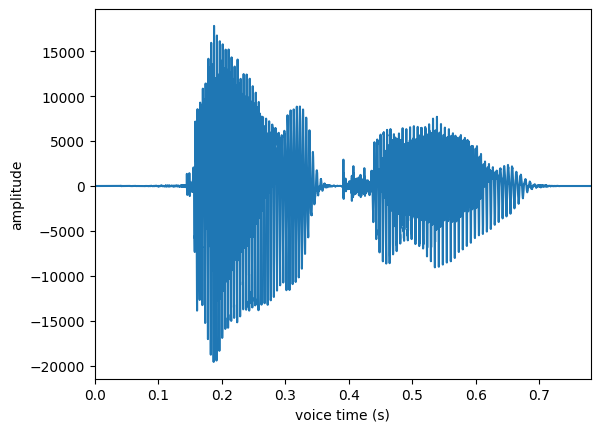

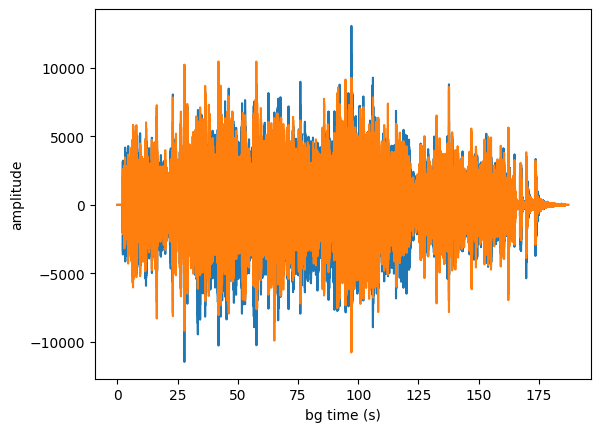

In [ ]:
# 나만의 소리 파일의 데이터와 샘플링 주기를 그래프로 출력하기

import numpy as np                          # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import scipy.io as sio                      # wav 형식으로 소리 데이터를 저장하기 위한 모듈
from scipy.io.wavfile import write          # wav 파일을 시스템 명령어로 재생하기 위한 모듈
import os

# sampling rate
v_samplerate, v_data = sio.wavfile.read("datasets/thank_you.wav")
b_samplerate, b_data = sio.wavfile.read("datasets/Invisible_Beauty.wav")

v_times = np.arange(len(v_data))/float(v_samplerate)
b_times = np.arange(len(b_data))/float(b_samplerate)

# ------------------------------------------------------------------------
import matplotlib.pyplot as plt                            # 소리 데이터의 그래프 표현을 위한 모듈

plt.plot(v_times, v_data)
plt.xlim(v_times[0], v_times[-1])
plt.xlabel('voice time (s)')
plt.ylabel('amplitude')
plt.show()

plt.plot(b_times, b_data)
plt.xlabel('bg time (s)')
plt.ylabel('amplitude')
plt.show()

단계3: 나만의 소리 파일의 샘플링 주파수와 채널 타입 바꾸기

In [ ]:
# 나만의 소리 파일의 샘플링 주기와 채널 타입 바꾸기

import numpy as np                                         # 행렬 및 벡터 데이터 관리를 위한 numpy 모듈
import matplotlib.pyplot as plt                            # 소리 데이터의 그래프 표현을 위한 모듈
import scipy.io as sio
from scipy.io.wavfile import write                         # wav 파일을 시스템 명령어로 재생하기 위한 모듈
import os

# sampling rate
v_samplerate, v_data = sio.wavfile.read('datasets/thank_you.wav')
b_samplerate, b_data = sio.wavfile.read("datasets/Invisible_Beauty.wav")

v_times = np.arange(len(v_data))/float(v_samplerate)
b_times = np.arange(len(b_data))/float(b_samplerate)

# ------------------------------------------------------------------------

# stereo channel -> mono channel
if (len(v_data.shape) > 1) :
   v_data = np.array(v_data[:,0])
if (len(b_data.shape) > 1) :
   b_data = np.array(b_data[:,0])

# 샘플링 주기 낮추기
if (v_samplerate > b_samplerate) :
   diffRate = v_samplerate / b_samplerate
   v_data = np.array(v_data[0:len(v_data):diffRate])
   sr = b_samplerate
elif (v_samplerate < b_samplerate) :
   diffRate = int(b_samplerate / v_samplerate)
   b_data = np.array(b_data[0:len(b_data):diffRate])
   sr = v_samplerate
else :
   sr = b_samplerate

# 10초 지점의 배경 음악과 음성 데이터 합성하기
mix_data = v_data + b_data[sr*10:len(v_data)+sr*10]

# 합성한 데이터를 배경 음악 10초 위치에 넣기
b_data[sr*10:len(v_data)+sr*10] = mix_data

# 합성한 파일을 wav 파일로 저장하기
scaled = np.int16(b_data/np.max(np.abs(b_data)) * 32767)
write('music_card.wav', sr, scaled)
os.system("start music_card.wav")

0

## 편곡하는 인공지능

### ABC 악보 표기

In [ ]:
pip install music21

  Using cached chardet-5.2.0-py3-none-any.whl.metadata (3.4 kB)
   ---------------------------------------- 0.0/22.8 MB ? eta -:--:--
   ------ --------------------------------- 3.6/22.8 MB 114.3 MB/s eta 0:00:01
   --------- ------------------------------ 5.5/22.8 MB 50.0 MB/s eta 0:00:01
   ---------- ----------------------------- 6.1/22.8 MB 38.7 MB/s eta 0:00:01
   ------------- -------------------------- 7.7/22.8 MB 40.7 MB/s eta 0:00:01
   ---------------- ----------------------- 9.3/22.8 MB 37.2 MB/s eta 0:00:01
   ------------------ --------------------- 10.5/22.8 MB 34.4 MB/s eta 0:00:01
   --------------------- ------------------ 12.4/22.8 MB 31.2 MB/s eta 0:00:01
   ------------------------------------ --- 21.1/22.8 MB 93.9 MB/s eta 0:00:01
   ---------------------------------------  22.8/22.8 MB 165.0 MB/s eta 0:00:01
   ---------------------------------------  22.8/22.8 MB 165.0 MB/s eta 0:00:01
   ---------------------------------------  22.8/22.8 MB 165.0 MB/s eta 0:00:0

In [ ]:
import music21

# "작은 별" 악보를 ABC 표기로 표현
little_star="tinynotation: 4/4 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2 g4 g4 f4 f4 e4 e4 d2 g4 g4 f4 f4 e4 e4 d2 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2"
music21.converter.parse(little_star).show('mid') # 스피커로 연주를 들려줌

import numpy as np

# 계이름과 숫자를 상호 변환하는 표(딕셔너리 자료구조를 사용함)
note2num={'c':1,'d':2,'e':3,'f':4,'g':5,'a':6,'b':7}
num2note={1:'c',2:'d',3:'e',4:'f',5:'g',6:'a',7:'b'}

# ABC 표기를 시계열 데이터로 변환
def abc2timeseries(s):
    notes=s.split(' ')[2:]
    seq=[]
    for i in notes:
        seq.append([note2num[i[0]],int(i[1])])
    return seq

# 시계열 데이터를 ABC 표기로 변환
def timeseries2abc(t):
    s='tinynotation: 4/4'
    for i in t:
        s=s+' '+num2note[i[0]]+str(i[1])
    return s

# 원핫 코드로 변환하는 표
onehot=[[1,2],[2,2],[3,2],[4,2],[5,2],[6,2],[7,2],[1,4],[2,4],[3,4],[4,4],[5,4],[6,4],[7,4],[1,8],[2,8],[3,8],[4,8],[5,8],[6,8],[7,8]]

# 레이블을 원핫 코드로 변환
def to_onehot(l):
    t=[]
    for i in range(len(l)):
        a=np.zeros(len(onehot))
        a[onehot.index(list(l[i]))]=1.0
        t.append(a)
    return np.array(t)

# 시계열 데이터를 훈련 집합으로 자름
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w=8 # 윈도우 크기
h=1 # 수평선 계수

seq=abc2timeseries(little_star)
X,Y=seq2dataset(seq,w,h)
print(X.shape,Y.shape)
print(X[0],Y[0])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf

# 훈련 집합 구축
split=int(len(X)*1.0) # 100%를 훈련집합으로 사용
x_train=X[0:split]; y_train=Y[0:split]
y_train=to_onehot(y_train)

# LSTM 모델 설계와 학습
model=Sequential()
model.add(LSTM(units=128,activation='relu',input_shape=x_train[0].shape))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=200,batch_size=1,verbose=2)

# 학습된 모델로 편곡을 하는 함수(first_measure: 첫 소절, duration: 생성될 곡의 길이)
def arranging_music(model,first_measure,duration):
    music=first_measure
    for i in range(duration):
        p=model.predict(np.float32(np.expand_dims(music[-w:],axis=0)))
        music=np.append(music,[onehot[np.argmax(p)]],axis=0)
    return timeseries2abc(music)

new_song=arranging_music(model,x_train[0],50)

print(new_song)
music21.converter.parse(new_song).show('mid')

(34, 8, 2) (34, 2)
[[1 4]
 [1 4]
 [5 4]
 [5 4]
 [6 4]
 [6 4]
 [5 2]
 [4 4]] [4 4]
Epoch 1/200


c:\DEV\py3_10_tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 - 3s - 83ms/step - accuracy: 0.2059 - loss: 2.8304
Epoch 2/200
34/34 - 0s - 4ms/step - accuracy: 0.2353 - loss: 2.2086
Epoch 3/200
34/34 - 0s - 8ms/step - accuracy: 0.1471 - loss: 2.0810
Epoch 4/200
34/34 - 0s - 5ms/step - accuracy: 0.2353 - loss: 1.9737
Epoch 5/200
34/34 - 0s - 5ms/step - accuracy: 0.2353 - loss: 1.9263
Epoch 6/200
34/34 - 0s - 6ms/step - accuracy: 0.2647 - loss: 1.7991
Epoch 7/200
34/34 - 0s - 5ms/step - accuracy: 0.4118 - loss: 1.6623
Epoch 8/200
34/34 - 0s - 6ms/step - accuracy: 0.4412 - loss: 1.5691
Epoch 9/200
34/34 - 0s - 6ms/step - accuracy: 0.3824 - loss: 1.5258
Epoch 10/200
34/34 - 0s - 5ms/step - accuracy: 0.5294 - loss: 1.4019
Epoch 11/200
34/34 - 0s - 9ms/step - accuracy: 0.3529 - loss: 1.5294
Epoch 12/200
34/34 - 0s - 6ms/step - accuracy: 0.5294 - loss: 1.3193
Epoch 13/200
34/34 - 0s - 5ms/step - accuracy: 0.4706 - loss: 1.2134
Epoch 14/200
34/34 - 0s - 5ms/step - accuracy: 0.4118 - loss: 1.3254
Epoch 15/200
34/34 - 0s - 5ms/step - accuracy: 0.5000 

In [ ]:
import music21

# "작은 별", "봄나들이", "나비야 나비야" 악보를 ABC 표기로 표현
little_star="tinynotation: 4/4 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2 g4 g4 f4 f4 e4 e4 d2 g4 g4 f4 f4 e4 e4 d2 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2"
spring_picnic="tinynotation: 4/8 g8 e8 g8 e8 g8 a8 g4 e8 g8 e8 c8 d8 e8 c4 g8 e8 g8 e8 g8 a8 g4 b8 a8 g8 e8 d8 e8 c4"
butterfly="tinynotation: 2/4 g8 e8 e4 f8 d8 d4 c8 d8 e8 f8 g8 g8 g4 g8 e8 e8 e8 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 e8 f8 g4 g8 e8 e4 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4"

import numpy as np

# 계이름과 숫자를 상호 변환하는 표
note2num={'c':1,'d':2,'e':3,'f':4,'g':5,'a':6,'b':7}
num2note={1:'c',2:'d',3:'e',4:'f',5:'g',6:'a',7:'b'}

# ABC 표기를 시계열 데이터로 변환
def abc2timeseries(s):
    notes=s.split(' ')[2:]
    seq=[]
    for i in notes:
        seq.append([note2num[i[0]],int(i[1])])
    return seq

# 시계열 데이터를 ABC 표기로 변환
def timeseries2abc(t):
    s='tinynotation: 4/4'
    for i in t:
        s=s+' '+num2note[i[0]]+str(i[1])
    return s

# 원핫 코드로 변환하는 표
onehot=[[1,2],[2,2],[3,2],[4,2],[5,2],[6,2],[7,2],[1,4],[2,4],[3,4],[4,4],[5,4],[6,4],[7,4],[1,8],[2,8],[3,8],[4,8],[5,8],[6,8],[7,8]]

# 레이블을 원핫 코드로 변환
def to_onehot(l):
    t=[]
    for i in range(len(l)):
        a=np.zeros(len(onehot))
        a[onehot.index(list(l[i]))]=1.0
        t.append(a)
    return np.array(t)

# 시계열 데이터를 훈련 집합으로 자름
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w=8 # 윈도우 크기
h=1 # 수평선 계수

# 세 곡을 시계열로 변환하고 결합
seq1=abc2timeseries(little_star)
seq2=abc2timeseries(butterfly)
seq3=abc2timeseries(spring_picnic)
seq=seq1+seq2+seq3

X,Y = seq2dataset(seq,w,h)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf

# 훈련 집합 구축
split=int(len(X)*1.0) # 100%를 훈련집합으로 사용
x_train=X[0:split]; y_train=Y[0:split]
y_train=to_onehot(y_train)

# LSTM 모델 설계와 학습
model=Sequential()
model.add(LSTM(units=128,activation='relu',input_shape=x_train[0].shape))
model.add(Dense(y_train.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=200,batch_size=1,verbose=2)

# 학습된 모델로 편곡을 하는 함수(first_measure: 첫 소절, duration: 생성될 곡의 길이)
def arranging_music(model,first_measure,duration):
    music=first_measure
    for i in range(duration):
        p=model.predict(np.float32(np.expand_dims(music[-w:],axis=0)))
        music=np.append(music,[onehot[np.argmax(p)]],axis=0)
    return timeseries2abc(music)

new_song=arranging_music(model,x_train[0],50)

print(new_song)
music21.converter.parse(new_song).show('mid')

Epoch 1/200


c:\DEV\py3_10_tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


116/116 - 2s - 20ms/step - accuracy: 0.1724 - loss: 2.6388
Epoch 2/200
116/116 - 0s - 3ms/step - accuracy: 0.2414 - loss: 2.3572
Epoch 3/200
116/116 - 0s - 3ms/step - accuracy: 0.2845 - loss: 2.2777
Epoch 4/200
116/116 - 0s - 3ms/step - accuracy: 0.2931 - loss: 2.2028
Epoch 5/200
116/116 - 0s - 3ms/step - accuracy: 0.2931 - loss: 2.1638
Epoch 6/200
116/116 - 0s - 3ms/step - accuracy: 0.3103 - loss: 2.0834
Epoch 7/200
116/116 - 0s - 3ms/step - accuracy: 0.3621 - loss: 2.0168
Epoch 8/200
116/116 - 0s - 3ms/step - accuracy: 0.3190 - loss: 2.0153
Epoch 9/200
116/116 - 0s - 3ms/step - accuracy: 0.3534 - loss: 1.9369
Epoch 10/200
116/116 - 0s - 3ms/step - accuracy: 0.3017 - loss: 1.9595
Epoch 11/200
116/116 - 0s - 3ms/step - accuracy: 0.3966 - loss: 1.8788
Epoch 12/200
116/116 - 0s - 3ms/step - accuracy: 0.3103 - loss: 1.9578
Epoch 13/200
116/116 - 0s - 3ms/step - accuracy: 0.3621 - loss: 1.8348
Epoch 14/200
116/116 - 0s - 3ms/step - accuracy: 0.3534 - loss: 1.8106
Epoch 15/200
116/116 - 0s 